<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-packages-and-data" data-toc-modified-id="Load-packages-and-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load packages and data</a></span></li><li><span><a href="#Predictive-models" data-toc-modified-id="Predictive-models-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Predictive models</a></span><ul class="toc-item"><li><span><a href="#SVM-with-RBF-Kernel" data-toc-modified-id="SVM-with-RBF-Kernel-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>SVM with RBF-Kernel</a></span><ul class="toc-item"><li><span><a href="#With-smaller-subset-of-data" data-toc-modified-id="With-smaller-subset-of-data-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>With smaller subset of data</a></span><ul class="toc-item"><li><span><a href="#Hyperopt" data-toc-modified-id="Hyperopt-2.1.1.1"><span class="toc-item-num">2.1.1.1&nbsp;&nbsp;</span>Hyperopt</a></span></li></ul></li></ul></li><li><span><a href="#SVM-with-Polynomial-Kernel" data-toc-modified-id="SVM-with-Polynomial-Kernel-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SVM with Polynomial Kernel</a></span></li></ul></li></ul></div>

## Load packages and data

In [1]:
import pdb 
import glob
import copy
import math
import pickle

import numpy as np
import pandas as pd
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
 
import missingno  # for visualizing missing data

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, \
    GridSearchCV, StratifiedShuffleSplit, ShuffleSplit

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, \
    LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, \
    precision_recall_curve, average_precision_score, f1_score, \
    roc_curve, auc, roc_auc_score, make_scorer,\
    accuracy_score, balanced_accuracy_score

from sklearn.externals import joblib
from sklearn.utils import resample
from sklearn.utils.fixes import signature


# Set up pandas table display
pd.set_option('display.width', 120)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Set plotting options
sns.set() # Use seaborn defaults for plotting
%matplotlib inline 

In [2]:
# Load preprocessed training and test set, incl. feature names 

X_train = joblib.load('data_processed/X_train.joblib')
X_test = joblib.load('data_processed/X_test.joblib')
y_train = joblib.load('data_processed/y_train.joblib')
y_test = joblib.load('data_processed/y_test.joblib')
# X_train_s = joblib.load('data_processed/X_train_s.joblib')
# X_test_s = joblib.load('data_processed/X_test_s.joblib')
# y_train_s = joblib.load('data_processed/y_train_s.joblib')
# y_test_s = joblib.load('data_processed/y_test_s.joblib')
feature_names = joblib.load('data_processed/feature_names')
# feature_names_s = joblib.load('data_processed/feature_names_s')

In [4]:
# Create smaller subsets from data
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=500, random_state=1)
    
X_test_s, y_test_s = resample(
    X_test, y_test, 
    replace=False, n_samples=500, random_state=1)

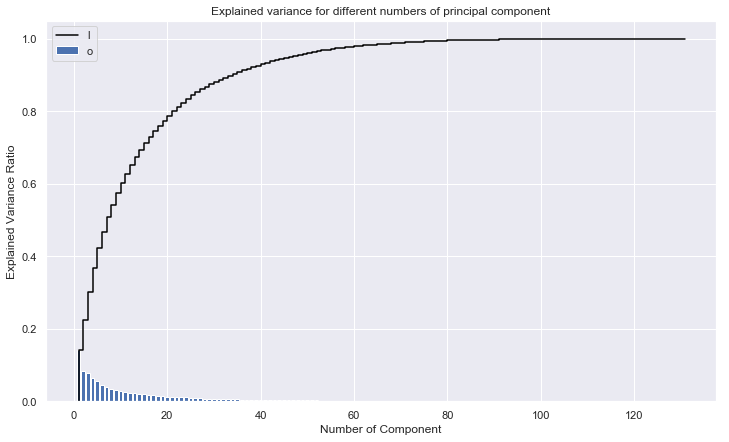

In [6]:
# Use PCA to assess whether features lie in lower-
# dimensional subspace
pca = PCA()
pca.fit(X_train)
explained_var = pca.explained_variance_ratio_

# Plot results
plt.figure(figsize=(12, 7))
plt.step(range(1, len(explained_var)+2),
         np.hstack([[0], np.cumsum(explained_var)]),
         color='black', label='Cumulative')
plt.bar(range(1, len(explained_var)+1),
        explained_var, 
        label='per principal component')
plt.legend('lowerright')
plt.title('Explained variance for different numbers of principal component')
plt.ylim(0,1.05)
plt.xlabel('Number of Component')
plt.ylabel('Explained Variance Ratio')
plt.show();

In [31]:

pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train_s) 
X_test_pc = pca.transform(X_test_s)

In [29]:
X_train_pc.shape

(500, 30)

## Predictive models

In [7]:
# Adjust parameters
N_JOBS = 1
max_eval = 2

### SVM with RBF-Kernel

#### With smaller subset of data

In [10]:
%%time
svm_rbf_1 = SVC(kernel='rbf', probability=False, 
              cache_size=5000, class_weight='balanced')
# Parameters to search over
param_grid = {'C': np.logspace(-3, 3, 8),
              'gamma': np.logspace(-5, 1, 8)}
# Define indices for validation split (instead of proper cross-validation)
split_indices = ShuffleSplit(n_splits=1, test_size=.2, random_state=1)

svm_rbf_gs_1 = GridSearchCV(svm_rbf_1, param_grid=param_grid,
                          return_train_score=True,
                          scoring='average_precision', cv=split_indices)
svm_rbf_gs_1.fit(X_train_s, y_train_s)

# Save model
joblib.dump(svm_rbf_gs_1, 'saved_models/svm_rbf_gs_1.joblib')

Wall time: 11.6 s


In [ ]:
# Load model
svm_rbf_gs_1 = joblib.load('saved_models/svm_rbf_gs_1.joblib')

In [ ]:
# Prediction of class
y_pred_svm_rbf_1 = svm_rbf_gs_1.predict(X_test_s)

# Distance from separating hyperplane
y_pred_distance_svm_rbf_1 = svm_rbf_gs_1.decision_function(X_test_s)

# Save results
average_precision_1['SVM (RBF Kernel)'] = \
    average_precision_score(y_test_s, y_pred_distance_svm_rbf_1)

classification_reports_1['SVM (RBF Kernel)'] = \
    classification_report(y_test_s, y_pred_svm_rbf_1)

In [ ]:
gs_best_result(svm_rbf_gs_1)

In [ ]:
gs_heatmap(svm_rbf_gs_1) #, x_digits=1, x_scientific_notation=False)

In [ ]:
pd.DataFrame(svm_rbf_gs_1.cv_results_)

##### Hyperopt

In [ ]:
# Create smaller subsets 
X_train_s, y_train_s = resample(
    X_train, y_train, 
    replace=False, n_samples=500, random_state=1)
    
X_test_s, y_test_s = resample(
    X_test, y_test, 
    replace=False, n_samples=500, random_state=1)

In [ ]:

pca = PCA(n_components=30)
X_train_pc = pca.fit_transform(X_train_s) 
X_test_pc = pca.transform(X_test_s)

In [ ]:
# Inspect prior distribution for reg_alpha
from hyperopt import pyll
c_distr = hp.lognormal('C', 0, 5)
samples = [pyll.stochastic.sample(c_distr) for i in range(1000)]
# 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('c_distr')
plt.title('Histogram for prior distribution of regularization strength')
plt.show()

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe())

In [ ]:
# Inspect prior distribution for reg_alpha
from hyperopt import pyll
gamma_distrdistr = hp.lognormal('C', np.log(1/30), 6)
samples = [pyll.stochastic.sample(gamma_distrdistr) for i in range(1000)]
# 
samples = list(filter(lambda x: x<100, samples))
# Plot
# sns.distplot(pd.Series(samples))
pd.Series(samples).plot(kind='hist', bins=50)
# plt.xlim([0,1000])
plt.xlabel('gamma_distrdistr')
plt.title('Histogram for prior distribution of regularization strength')
plt.show()

# Descriptive statistics
print('Descriptive statistics:\n', 
      pd.Series(samples).describe())

In [ ]:
def adjust_params_svm_rbf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Set min or max thresholds for parameters, where applicable
    if params['C'] >= 10:
        params['C'] = 10
        
    # Return modified parameters
    return params

In [ ]:
# import csv
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
# from sklearn.model_selection import cross_val_score, StratifiedKFold

In [ ]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""

        `# Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train_pc, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train_pc, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [ ]:
%%time
MAX_EVALS=40
N_JOBS=3

# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 1500000,
    'class_weight': 'balanced',
    'random_state': 1,
    'C': hp.lognormal('C', -3, 3),
    'gamma': hp.lognormal('gamma', -3, 3)
}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_pc, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=N_JOBS)

In [ ]:
# Load model
svm_rbf_hp = joblib.load('saved_models/svm_rbf_hp.joblib')

# Calculate average precision
def print_save_ap(clf, model_name, X_test_pc, y_test, validation_plot=False):
    """
    Calculates, saves, and prints average precision score on test set; 
    optionally plot how average precision changed over iterations.
    """

    # Score classifier with the test data
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test_pc)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test_pc)
   
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    
    # Save AP
    try:
        average_precision_hp[model_name] = ap_score
    # If dictionary to save AP doesn't exist yet, create it first
    except NameError:
        average_precision = {}
        average_precision[model_name] = ap_score
    
    # Print AP
    print('Best average precision score on *test* set: {}'.format(ap_score))
    
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance on *Validation* Set')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');

print_save_ap(svm_rbf_hp, 'svm_rbf_hp', X_test_pc, y_test_s, validation_plot=True)

###### OLD

In [59]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name,
                 X_train, y_train, 
                 n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, adjust_params, CLF=CLF, progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""

        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices is for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)
    
    

In [56]:
def adjust_params_svm_rbf(params):
    """ 
    Adjust parameters where hyperopt did not allow sampling from optimal 
    distribution.
    """

    # Set min or max thresholds for parameters, where applicable
    if params['C'] >= 10:
        params['C'] = 10
        
    # Return modified parameters
    return params

In [1]:
import csv
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [62]:
# Function to carry out hyperparameter optimization
def find_best_hp(CLF, space, model_name, 
                 X_train, y_train, 
                 adjust_params=None,n_folds=5, n_jobs=-1, max_evals=20):
    """Find best hyperparameters for a given classifier and search space."""
    
    # Trials object to track progress
    trials = Trials()

    # CSV file to track progress
    progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
    with open(progress_file_path, 'w') as file:
        writer = csv.writer(file)
        # Write header to the file
        writer.writerow(['loss', 'params'])

    # Objective function to minimize
    def objective(params, CLF=CLF, 
                  progress_file_path=progress_file_path,
                  n_folds=n_folds, n_jobs=n_jobs):
        """Objective function to minimize"""

        # Adjust parameters, if specified
        if adjust_params is not None:
            params = adjust_params(params)
    
        # Instantiate CLF
        clf = CLF(**params)
        
        ## Generate indices for cross-validation
        # If only one "fold" is desired, split into train and validation set
        if n_folds == 1: 
            cv = StratifiedShuffleSplit(n_splits=1, test_size=.2, 
                                        random_state=1)
        # Otherwise, generate indices for proper cross-validation split
        else:  
            cv = StratifiedKFold(n_folds, random_state=1)

        # Compute average precision through CV / validation set
        score = cross_val_score(clf, X_train_pc, y_train, cv=cv,
                                scoring='average_precision', n_jobs=n_jobs)
        # Compute loss as the negative mean of the average precision scores
        # (since hyperopt can only minimize a function)
        loss = -score.mean()
        
        # Save results to csv file
        with open(progress_file_path, 'a') as file:
            writer = csv.writer(file)
            writer.writerow([loss, params])
        
        # Return results
        return {'loss': loss, 'params': params, 'status': STATUS_OK}
    
    # Minimize objective
    best = fmin(objective, space, algo=tpe.suggest,
                max_evals=max_evals, trials=trials)

    # Get the values of the optimal parameters
    best_params = space_eval(space, best)

    # Fit the model with the optimal hyperparamters
    clf = CLF(**best_params)
    clf.fit(X_train_pc, y_train)
    
    # Save model to disk
    joblib.dump(clf, 'saved_models/' + model_name + '.joblib')
    
    # Print best parameters
    print(best_params)

In [63]:
%%time
MAX_EVALS=2
# Define search space
space = {
    'kernel': 'rbf',
    'cache_size': 1500000,
    'class_weight': 'balanced',
    'random_state': 1,
    'C': hp.loguniform('C', -3, 3),
    'gamma': hp.loguniform('gamma', -3, 3)
}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_rbf_hp',
              X_train=X_train_pc, y_train=y_train_s, 
              adjust_params=adjust_params_svm_rbf,
              max_evals=MAX_EVALS,n_folds=1, n_jobs=N_JOBS)

{'C': 2.161076141710819, 'cache_size': 1500000, 'class_weight': 'balanced', 'gamma': 2.1350385178500026, 'kernel': 'rbf', 'random_state': 1}
Wall time: 352 ms


Best average precision score on *test* set: 0.23588374889171582


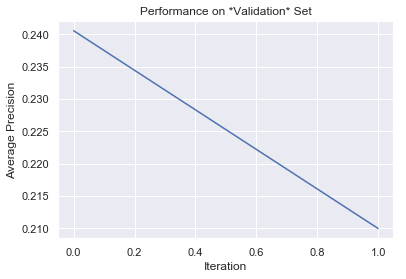

In [44]:
# Load model
svm_rbf_hp = joblib.load('saved_models/svm_rbf_hp.joblib')

# Calculate average precision
def print_save_ap(clf, model_name, X_test_pc, y_test, validation_plot=False):
    """
    Calculates, saves, and prints average precision score on test set; 
    optionally plot how average precision changed over iterations.
    """

    # Score classifier with the test data
    # Try if classifier supports probability
    try:
        y_score = clf.predict_proba(X_test_pc)[:,1]
    # If it doesn't, use its decision function
    except AttributeError:
        y_score = clf.decision_function(X_test_pc)
   
    # Calculate average precision
    ap_score = average_precision_score(y_test, y_score)
    
    # Save AP
    try:
        average_precision_hp[model_name] = ap_score
    # If dictionary to save AP doesn't exist yet, create it first
    except NameError:
        average_precision = {}
        average_precision[model_name] = ap_score
    
    # Print AP
    print('Best average precision score on *test* set: {}'.format(ap_score))
    
    
    # Plot AP, if specified
    if validation_plot:
        # Load progress file with validation performance
        progress_file_path = 'hp_progress/progress_' + model_name + '.csv'
        progress_file = pd.read_csv(progress_file_path)

        # Extract AP for each iteration
        ap = - progress_file.loss
        ap.plot()
        plt.title('Performance on *Validation* Set')
        plt.ylabel('Average Precision')
        plt.xlabel('Iteration');

print_save_ap(svm_rbf_hp, 'svm_rbf_hp', X_test_pc, y_test_s, validation_plot=True)

### SVM with Polynomial Kernel

In [32]:
%%time

# Define search space
space = {
    'kernel': 'poly',
    'cache_size': 1500000,
    'class_weight': 'balanced',
    'random_state': 1,
    'gamma': 'scale',
    'C': hp.loguniform('C', -3, 3),
    'degree': hp.choice('degree', [2, 3, 4])
}

# Find best hyperparameters
find_best_hp(SVC, space, model_name='svm_poly_hp',
              X_train=X_train_s, y_train=y_train_s,
              max_evals=MAX_EVALS, n_folds=1, n_jobs=N_JOBS)

{'C': 0.6089158751929603, 'cache_size': 1500000, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'poly', 'random_state': 1}
Wall time: 18.6 s


Best average precision score on *test* set: 0.259280120321705


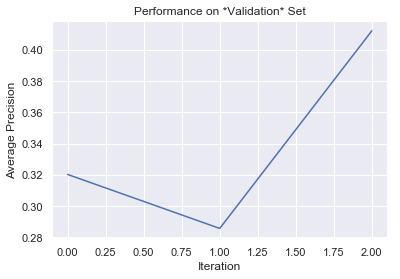

In [30]:
# Load model
svm_poly_hp = joblib.load('saved_models/svm_poly_hp.joblib')

# Print and save Average Precision
print_save_ap(svm_poly_hp, 'svm_poly_hp', X_test_s, y_test_s, validation_plot=True)